In [1]:
%load_ext autoreload
%autoreload 2

# Potential Outcome Model

> **Reference:** *Causal Inference: The Mixtape*, Chapter 4: Potential Outcomes Causal Model (pp. 119-174)

This lecture introduces the potential outcome framework for causal inference. We apply these concepts using the Online Retail Simulator to answer: **Does improving product content quality increase sales?**

## Setup

In [2]:
from IPython.display import Code
import inspect
from operator import itemgetter
import numpy as np

from online_retail_simulator import simulate, load_job_results
from online_retail_simulator.enrich import enrich

from support import (
    plot_individual_effects_distribution,
    plot_randomization_comparison,
    plot_balance_check,
    generate_quality_score,
)

np.random.seed(42)

---

# Part I: Theory

This section covers the theoretical foundations of the potential outcome framework as presented in Cunningham's *Causal Inference: The Mixtape*, Chapter 4.

## The Potential Outcome Framework

The potential outcome framework, also known as the Rubin Causal Model (RCM), provides a precise mathematical language for defining causal effects. The framework was developed by Donald Rubin in the 1970s, building on earlier work by Jerzy Neyman.

### Core Definitions

For each unit $i$ in a population, we define:

- $D_i \in \{0, 1\}$: **Treatment indicator** (1 if unit receives treatment, 0 otherwise)
- $Y_i^1$: **Potential outcome under treatment** — the outcome unit $i$ *would have* if treated
- $Y_i^0$: **Potential outcome under control** — the outcome unit $i$ *would have* if not treated

The key insight is that both potential outcomes exist conceptually for every unit, but we can only observe one of them.

### The Switching Equation

The **observed outcome** follows the switching equation:

$$Y_i = D_i \cdot Y_i^1 + (1 - D_i) \cdot Y_i^0$$

This equation formalizes which potential outcome we observe:
- If $D_i = 1$ (treated): we observe $Y_i = Y_i^1$
- If $D_i = 0$ (control): we observe $Y_i = Y_i^0$

## The Fundamental Problem of Causal Inference

Holland (1986) articulated what he called the *fundamental problem of causal inference*: **we cannot observe both potential outcomes for the same unit at the same time**.

Consider this example:

| Unit | Treatment | Observed | $Y^1$ | $Y^0$ |
|------|-----------|----------|-------|-------|
| A | Treated | \$500 | \$500 | ? |
| B | Control | \$300 | ? | \$300 |
| C | Treated | \$450 | \$450 | ? |
| D | Control | \$280 | ? | \$280 |

The question marks represent **counterfactuals** — outcomes that would have occurred under the alternative treatment assignment. These are fundamentally unobservable.

This is not a data limitation that can be solved with more observations or better measurement. It is a logical impossibility: the same unit cannot simultaneously exist in both treatment states.

## Individual Treatment Effects

The **individual treatment effect (ITE)** for unit $i$ is defined as:

$$\delta_i = Y_i^1 - Y_i^0$$

This measures how much unit $i$'s outcome would change due to treatment.

**Key insight:** Because we can never observe both $Y_i^1$ and $Y_i^0$ for the same unit, individual treatment effects are fundamentally unidentifiable. This is why causal inference focuses on *population-level* parameters instead.

## Population-Level Parameters

Since individual effects are unobservable, we focus on population averages:

| Parameter | Definition | Interpretation |
|-----------|------------|----------------|
| **ATE** | $E[Y^1 - Y^0]$ | Average effect across *all* units |
| **ATT** | $E[Y^1 - Y^0 \mid D=1]$ | Average effect among units that *were* treated |
| **ATC** | $E[Y^1 - Y^0 \mid D=0]$ | Average effect among units that *were not* treated |

### When Do These Differ?

If treatment effects are **homogeneous** (same for everyone), then $\text{ATE} = \text{ATT} = \text{ATC}$.

If treatment effects are **heterogeneous** and correlated with treatment selection, these parameters will differ. For example, if high-ability workers are more likely to get job training *and* benefit more from it, then $\text{ATT} > \text{ATE}$.

## The Naive Estimator and Selection Bias

The most intuitive approach to estimating causal effects is the **naive estimator** (also called the simple difference in means):

$$\hat{\delta}_{\text{naive}} = E[Y \mid D=1] - E[Y \mid D=0]$$

This compares average outcomes between treated and control groups. When does this equal the ATE?

### Decomposing the Naive Estimator

We can decompose the naive estimator as follows:

$$E[Y \mid D=1] - E[Y \mid D=0] = \underbrace{E[Y^1 - Y^0]}_{\text{ATE}} + \underbrace{E[Y^0 \mid D=1] - E[Y^0 \mid D=0]}_{\text{Selection Bias}}$$

The naive estimator equals the ATE only when **selection bias is zero**.

### What Causes Selection Bias?

Selection bias occurs when treatment assignment is correlated with potential outcomes:

$$\text{Selection Bias} = E[Y^0 \mid D=1] - E[Y^0 \mid D=0] \neq 0$$

This happens when treated units would have had *different* outcomes than control units *even without treatment*.

### Full Bias Decomposition (with Heterogeneous Effects)

When treatment effects vary across units, the full decomposition is:

$$\hat{\delta}_{\text{naive}} - \text{ATE} = \underbrace{E[Y^0 \mid D=1] - E[Y^0 \mid D=0]}_{\text{Baseline Bias}} + \underbrace{E[\delta \mid D=1] - E[\delta]}_{\text{Differential Treatment Effect Bias}}$$

- **Baseline bias**: Treated units have different baseline outcomes
- **Differential treatment effect bias**: Treated units have different treatment effects

## Randomization: The Gold Standard

**Randomized controlled trials (RCTs)** solve the selection bias problem by ensuring treatment is assigned independently of potential outcomes.

### Independence Assumption

Under randomization:

$$(Y^0, Y^1) \perp\!\!\!\perp D$$

This means potential outcomes are statistically independent of treatment assignment.

### Why Randomization Works

Under independence:

$$E[Y^0 \mid D=1] = E[Y^0 \mid D=0] = E[Y^0]$$
$$E[Y^1 \mid D=1] = E[Y^1 \mid D=0] = E[Y^1]$$

Therefore:

$$E[Y \mid D=1] - E[Y \mid D=0] = E[Y^1] - E[Y^0] = \text{ATE}$$

The naive estimator becomes **unbiased** under randomization.

## SUTVA: Stable Unit Treatment Value Assumption

The potential outcome framework relies on a critical assumption called SUTVA, which has two components:

### 1. No Interference

One unit's treatment assignment does not affect another unit's potential outcomes:

$$Y_i^d = Y_i^d(D_1, D_2, \ldots, D_n) \text{ depends only on } D_i$$

**Violations:**
- Vaccine trials: Your vaccination protects others (herd immunity)
- Classroom interventions: Tutoring one student may help their study partners
- Market interventions: Promoting one product may cannibalize another

### 2. No Hidden Variations in Treatment

Treatment is well-defined — there is only one version of "treatment" and one version of "control":

$$Y_i^1 \text{ is the same regardless of how treatment is administered}$$

**Violations:**
- Drug dosage varies across treated patients
- Job training programs have different instructors
- "Content optimization" could mean different things for different products

---

# Part II: Application

We now apply the potential outcome framework to a business question using simulated data. The simulator gives us a "god's eye view" — we observe both potential outcomes, allowing us to compute true treatment effects and validate our estimators.

## Business Question

**Does improving product content quality increase sales?**

An e-commerce company is considering investing in content optimization (better descriptions, images, etc.) for its product catalog. Before rolling this out to all products, they want to understand the causal effect of content optimization on revenue.

In our simulation:
- **Treatment ($D=1$)**: Product receives content optimization
- **Control ($D=0$)**: Product keeps original content
- **Outcome ($Y$)**: Product revenue

## Data Generation

We simulate 500 products with a single day of sales data. This gives us cross-sectional data: one revenue observation per product.

In [3]:
print(open("config_simulation.yaml").read())

STORAGE:
  PATH: output

RULE:
  CHARACTERISTICS:
    FUNCTION: simulate_characteristics_rule_based
    PARAMS:
      num_products: 500
      seed: 42

  METRICS:
    FUNCTION: simulate_metrics_rule_based
    PARAMS:
      date_start: "2024-11-15"
      date_end: "2024-11-15"
      sale_prob: 0.7
      seed: 42

PRODUCT_DETAILS:
  FUNCTION: simulate_product_details_mock



In [4]:
# Run simulation
job_info = simulate("config_simulation.yaml")
products, metrics_ = itemgetter("products", "metrics")(load_job_results(job_info))

print(f"Products: {len(products)}")
print(f"Metrics records: {len(metrics_)}")
print(f"Date: {metrics_['date'].unique()[0]}")

Products: 500
Metrics records: 500
Date: 2024-11-15


### Treatment Effect Configuration

The simulator's enrichment pipeline applies treatment effects. Here's the configuration for random treatment assignment with a 50% boost to sales quantity:

In [5]:
print(open("config_enrichment_random.yaml").read())

IMPACT:
  FUNCTION: quantity_boost
  PARAMS:
    effect_size: 0.5
    enrichment_fraction: 0.3
    enrichment_start: "2024-11-15"
    seed: 42



In [6]:
from online_retail_simulator.enrich.enrichment_library import quantity_boost

Code(inspect.getsource(quantity_boost), language="python")

def quantity_boost(metrics: list, **kwargs) -> tuple:
    """
    Boost ordered units by a percentage for enriched products.

    Args:
        metrics: List of metric record dictionaries
        **kwargs: Parameters including:
            - effect_size: Percentage increase in ordered units (default: 0.5 for 50% boost)
            - enrichment_fraction: Fraction of products to enrich (default: 0.3)
            - enrichment_start: Start date of enrichment (default: "2024-11-15")
            - seed: Random seed for product selection (default: 42)
            - min_units: Minimum units for enriched products with zero sales (default: 1)

    Returns:
        Tuple of (treated_metrics, potential_outcomes_df):
            - treated_metrics: List of modified metric dictionaries with treatment applied
            - potential_outcomes_df: DataFrame with Y0_revenue and Y1_revenue for all products
    """
    effect_size = kwargs.get("effect_size", 0.5)
    enrichment_fraction = kwargs.get("enrichment_fraction", 0.3)
    enrichment_start = kwargs.get("enrichment_start", "2024-11-15")
    seed = kwargs.get("seed", 42)
    min_units = kwargs.get("min_units", 1)

    if seed is not None:
        random.seed(seed)

    unique_products = list(set(record["product_id"] for record in metrics))
    n_enriched = int(len(unique_products) * enrichment_fraction)
    enriched_product_ids = set(random.sample(unique_products, n_enriched))

    treated_metrics = []
    potential_outcomes = {}  # {(product_id, date): {'Y0_revenue': x, 'Y1_revenue': y}}
    start_date = datetime.strptime(enrichment_start, "%Y-%m-%d")

    for record in metrics:
        record_copy = copy.deepcopy(record)
        product_id = record_copy["product_id"]
        record_date_str = record_copy["date"]
        record_date = datetime.strptime(record_date_str, "%Y-%m-%d")

        is_enriched = product_id in enriched_product_ids
        record_copy["enriched"] = is_enriched

        # Calculate Y(0) - baseline revenue (no treatment)
        y0_revenue = record_copy["revenue"]

        # Calculate Y(1) - revenue if treated (for ALL products)
        unit_price = record_copy.get("unit_price", record_copy.get("price"))
        if record_date >= start_date:
            original_quantity = record_copy["ordered_units"]
            boosted_quantity = int(original_quantity * (1 + effect_size))
            boosted_quantity = max(min_units, boosted_quantity)
            y1_revenue = round(boosted_quantity * unit_price, 2)
        else:
            # Before treatment start, Y(1) = Y(0)
            y1_revenue = y0_revenue

        # Store potential outcomes for ALL products
        key = (product_id, record_date_str)
        potential_outcomes[key] = {"Y0_revenue": y0_revenue, "Y1_revenue": y1_revenue}

        # Apply factual outcome (only for treated products)
        if is_enriched and record_date >= start_date:
            record_copy["ordered_units"] = boosted_quantity
            record_copy["revenue"] = y1_revenue

        treated_metrics.append(record_copy)

    # Build potential outcomes DataFrame
    potential_outcomes_df = pd.DataFrame(
        [
            {
                "product_identifier": pid,
                "date": d,
                "Y0_revenue": v["Y0_revenue"],
                "Y1_revenue": v["Y1_revenue"],
            }
            for (pid, d), v in potential_outcomes.items()
        ]
    )

    return treated_metrics, potential_outcomes_df

In [7]:
# Apply random treatment using enrichment pipeline
enrich("config_enrichment_random.yaml", job_info)

products, metrics_, metrics_enriched = itemgetter("products", "metrics", "enriched")(load_job_results(job_info))
print(f"Baseline revenue: ${metrics_['revenue'].sum():,.0f}")
print(f"Enriched revenue: ${metrics_enriched['revenue'].sum():,.0f}")

Baseline revenue: $18,703
Enriched revenue: $42,069


## Simulator Advantage: Full Information

Unlike real data, our simulator gives us **both potential outcomes** for every product. This "god's eye view" lets us:
1. Compute true individual treatment effects
2. Calculate true population parameters (ATE, ATT, ATC)
3. Validate whether our estimators are biased

### The Fundamental Problem in Practice

First, let's see what we would observe in real data — only one potential outcome per product:

In [8]:
# What we OBSERVE in real data
fundamental_df = metrics_enriched[["product_identifier", "revenue", "enriched"]].copy()
fundamental_df.columns = ["Product", "Observed", "Treated"]

# Impute potential outcomes - we only observe ONE
fundamental_df["Y\u00b9"] = np.where(fundamental_df["Treated"], fundamental_df["Observed"], np.nan)
fundamental_df["Y\u2070"] = np.where(~fundamental_df["Treated"], fundamental_df["Observed"], np.nan)

# Show products with positive revenue for clearer illustration
sample = fundamental_df[fundamental_df["Observed"] > 0].sample(8, random_state=42)
sample["Treated"] = sample["Treated"].map({True: "Yes", False: "No"})
sample[["Product", "Treated", "Observed", "Y\u00b9", "Y\u2070"]]

,Product,Treated,Observed,Y¹,Y⁰
51,BYR0QF4B8D,No,235.53,NaN,235.53
119,BGP1Z7FZTV,Yes,95.79,95.79,NaN
430,B38R92I8L3,Yes,87.78,87.78,NaN
324,BCMVO84W6T,Yes,23.21,23.21,NaN
412,BVE9L4UWNR,Yes,35.32,35.32,NaN
43,BH3I379U26,Yes,55.87,55.87,NaN
58,BUL5NWQVRR,Yes,75.48,75.48,NaN
191,B72HN5F62D,Yes,177.50,177.50,NaN


### Full Information View

Now let's see what the simulator actually knows — both potential outcomes:

In [9]:
# Load all results including potential outcomes
results = load_job_results(job_info)
potential_outcomes = results["potential_outcomes"]

# Merge with enriched metrics to get treatment indicator
full_info_df = potential_outcomes.merge(
    metrics_enriched[["product_identifier", "enriched", "revenue"]],
    on="product_identifier",
)
full_info_df = full_info_df.rename(
    columns={
        "Y0_revenue": "Y\u2070",
        "Y1_revenue": "Y\u00b9",
        "enriched": "Treated",
        "revenue": "Y_obs",
    }
)

# Show sample with positive revenue
sample = full_info_df[full_info_df["Y\u2070"] > 0].sample(8, random_state=42)
sample["Treated"] = sample["Treated"].map({True: "Yes", False: "No"})
sample[["product_identifier", "Treated", "Y_obs", "Y\u2070", "Y\u00b9"]]

,product_identifier,Treated,Y_obs,Y⁰,Y¹
152,BNS5MHIE2L,No,215.65,215.65,215.65
444,B5FVDDWJ8G,No,122.02,122.02,183.03
437,BBLGSRI2AO,Yes,5824.36,4368.27,5824.36
80,BST5J284WV,No,746.58,746.58,995.44
414,BWJGHF5A8C,Yes,207.28,155.46,207.28
22,BD8DUDD467,No,77.04,77.04,77.04
139,B3EH58B6PJ,No,791.48,791.48,1187.22
470,B8NN87Q94J,No,2124.88,2124.88,3187.32


### Individual Treatment Effects

Because we have both potential outcomes, we can compute true individual treatment effects:

In [10]:
# Individual treatment effect: delta_i = Y^1_i - Y^0_i
full_info_df["delta"] = full_info_df["Y\u00b9"] - full_info_df["Y\u2070"]

print("Individual Treatment Effects:")
print(f"  Mean: ${full_info_df['delta'].mean():,.2f}")
print(f"  Std:  ${full_info_df['delta'].std():,.2f}")
print(f"  Min:  ${full_info_df['delta'].min():,.2f}")
print(f"  Max:  ${full_info_df['delta'].max():,.2f}")

Individual Treatment Effects:
  Mean: $174.52
  Std:  $278.41
  Min:  $0.00
  Max:  $1,480.98


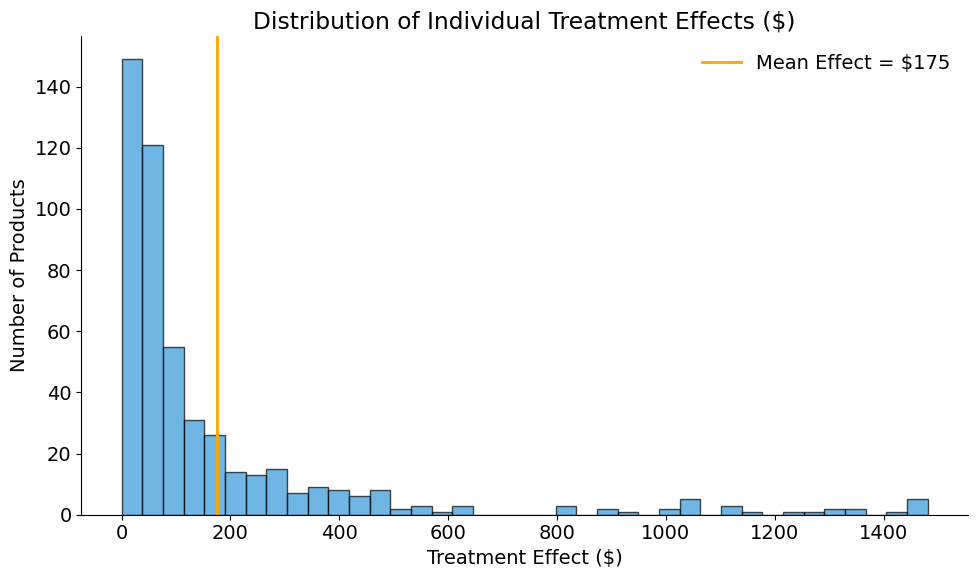

In [11]:
plot_individual_effects_distribution(
    full_info_df["delta"],
    title="Distribution of Individual Treatment Effects ($)",
)

### True Population Parameters

In [12]:
# True ATE (we know both potential outcomes for all units)
ATE_true = full_info_df["delta"].mean()

print(f"True ATE: ${ATE_true:,.2f}")
print("\nThis is the average revenue increase from content optimization.")

True ATE: $174.52

This is the average revenue increase from content optimization.


## Scenario 1: Random Treatment Assignment

Our current simulation uses **random treatment assignment**. Let's verify that the naive estimator is unbiased under randomization.

In [13]:
# Naive estimator under random assignment
treated = full_info_df[full_info_df["Treated"]]
control = full_info_df[~full_info_df["Treated"]]

naive_estimate_random = treated["Y_obs"].mean() - control["Y_obs"].mean()

print("Naive Estimator (Random Assignment):")
print(f"  E[Y | D=1] = ${treated['Y_obs'].mean():,.2f}")
print(f"  E[Y | D=0] = ${control['Y_obs'].mean():,.2f}")
print(f"  Naive estimate = ${naive_estimate_random:,.2f}")
print(f"\nTrue ATE = ${ATE_true:,.2f}")
print(f"Bias = ${naive_estimate_random - ATE_true:,.2f}")

Naive Estimator (Random Assignment):
  E[Y | D=1] = $209.91
  E[Y | D=0] = $30.24
  Naive estimate = $179.67

True ATE = $174.52
Bias = $5.16


### Covariate Balance Under Randomization

Let's add a quality score (representing existing content quality) and check balance between groups:

In [14]:
# Add quality score based on baseline revenue (Y^0)
full_info_df["quality_score"] = generate_quality_score(full_info_df["Y\u2070"])

print(f"Quality score range: {full_info_df['quality_score'].min():.1f} - {full_info_df['quality_score'].max():.1f}")
print(f"Correlation(quality, Y\u2070): {full_info_df['quality_score'].corr(full_info_df['Y\u2070']):.2f}")

Quality score range: 1.0 - 4.5
Correlation(quality, Y⁰): 0.53


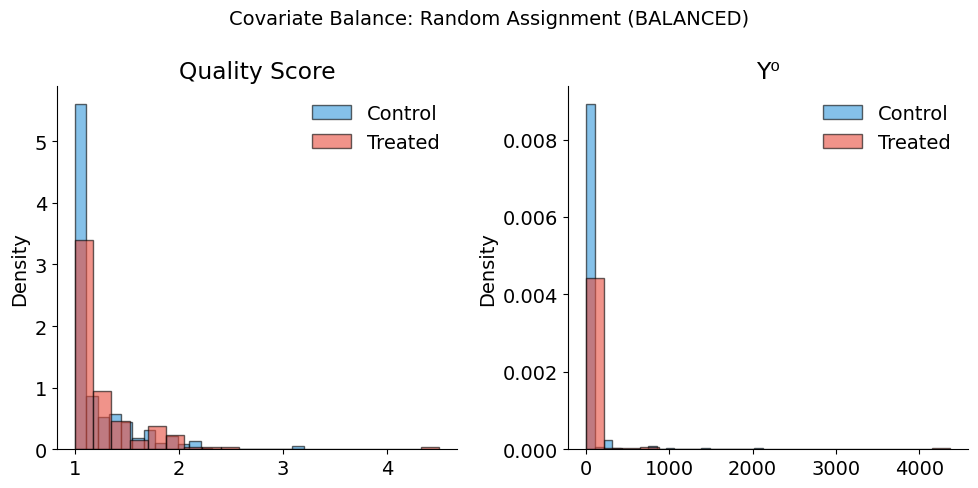


Balance Summary (Mean by Treatment Status):
--------------------------------------------------
quality_score       : Control=    1.20, Treated=    1.24, Diff=   +0.04
Y⁰                  : Control=   30.24, Treated=   54.14, Diff=  +23.90


In [15]:
# Check balance under random assignment
full_info_df["D_random"] = full_info_df["Treated"].astype(int)

plot_balance_check(
    full_info_df,
    covariates=["quality_score", "Y\u2070"],
    treatment_col="D_random",
    title="Covariate Balance: Random Assignment (BALANCED)",
)

## Scenario 2: Quality-Based Selection (The Real World)

In practice, businesses rarely randomize. Instead, they **select products strategically** — often treating high-performing products first.

Let's simulate a realistic scenario where:
- The company selects the top 30% of products by quality score for content optimization
- This creates correlation between quality and treatment

In [16]:
# Quality-based selection: treat TOP 30% by quality
n_treat = int(len(full_info_df) * 0.3)
treated_ids = set(full_info_df.nlargest(n_treat, "quality_score")["product_identifier"])
full_info_df["D_biased"] = full_info_df["product_identifier"].isin(treated_ids).astype(int)

# Observed outcome under biased selection
full_info_df["Y_biased"] = np.where(full_info_df["D_biased"] == 1, full_info_df["Y\u00b9"], full_info_df["Y\u2070"])

print(f"Treatment selection: Top {n_treat} products by quality score")
print(f"Treated products: {full_info_df['D_biased'].sum()}")

Treatment selection: Top 150 products by quality score
Treated products: 150


In [17]:
# Naive estimator under quality-based selection
treated_biased = full_info_df[full_info_df["D_biased"] == 1]
control_biased = full_info_df[full_info_df["D_biased"] == 0]

naive_estimate_biased = treated_biased["Y_biased"].mean() - control_biased["Y_biased"].mean()

print("Naive Estimator (Quality-Based Selection):")
print(f"  E[Y | D=1] = ${treated_biased['Y_biased'].mean():,.2f}")
print(f"  E[Y | D=0] = ${control_biased['Y_biased'].mean():,.2f}")
print(f"  Naive estimate = ${naive_estimate_biased:,.2f}")
print(f"\nTrue ATE = ${ATE_true:,.2f}")
print(f"Bias = ${naive_estimate_biased - ATE_true:,.2f}")
print("\nThe naive estimator is BIASED under non-random selection!")

Naive Estimator (Quality-Based Selection):
  E[Y | D=1] = $294.80
  E[Y | D=0] = $12.94
  Naive estimate = $281.86

True ATE = $174.52
Bias = $107.34

The naive estimator is BIASED under non-random selection!


### Bias Decomposition

Let's verify the theoretical bias decomposition with our simulated data:

In [18]:
# Baseline bias: E[Y^0 | D=1] - E[Y^0 | D=0]
baseline_treated = full_info_df[full_info_df["D_biased"] == 1]["Y\u2070"].mean()
baseline_control = full_info_df[full_info_df["D_biased"] == 0]["Y\u2070"].mean()
baseline_bias = baseline_treated - baseline_control

# Differential treatment effect bias: E[delta | D=1] - E[delta]
ATT = full_info_df[full_info_df["D_biased"] == 1]["delta"].mean()
differential_effect_bias = ATT - ATE_true

print("Bias Decomposition:")
print(f"  Baseline bias:                ${baseline_bias:,.2f}  (treated have higher Y\u2070)")
print(f"  Differential treatment effect: ${differential_effect_bias:,.2f}")
print("  " + "\u2500" * 40)
print(f"  Total bias:                   ${baseline_bias + differential_effect_bias:,.2f}")
print(f"\nActual bias (Naive - ATE):      ${naive_estimate_biased - ATE_true:,.2f}")

Bias Decomposition:
  Baseline bias:                $81.56  (treated have higher Y⁰)
  Differential treatment effect: $25.78
  ────────────────────────────────────────
  Total bias:                   $107.34

Actual bias (Naive - ATE):      $107.34


### Covariate Imbalance Under Biased Selection

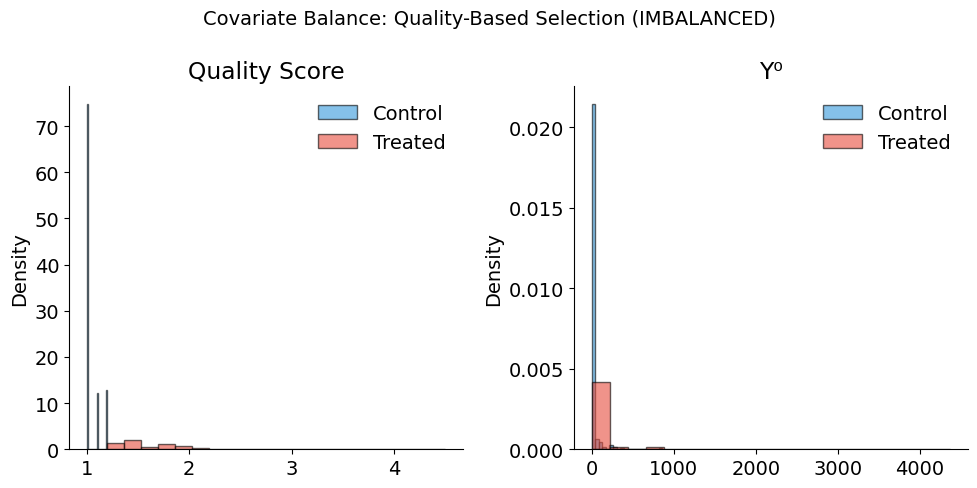


Balance Summary (Mean by Treatment Status):
--------------------------------------------------
quality_score       : Control=    1.04, Treated=    1.61, Diff=   +0.58
Y⁰                  : Control=   12.94, Treated=   94.50, Diff=  +81.56


In [19]:
plot_balance_check(
    full_info_df,
    covariates=["quality_score", "Y\u2070"],
    treatment_col="D_biased",
    title="Covariate Balance: Quality-Based Selection (IMBALANCED)",
)

## Monte Carlo Demonstration

Let's run many simulations to see the sampling distribution of the naive estimator under random vs. biased selection:

In [20]:
# Monte Carlo simulation
n_simulations = 500
n_treat = int(len(full_info_df) * 0.3)

random_estimates = []
biased_estimates = []

for i in range(n_simulations):
    # Random selection
    random_idx = np.random.choice(len(full_info_df), n_treat, replace=False)
    D_random = np.zeros(len(full_info_df))
    D_random[random_idx] = 1
    Y_random = np.where(D_random == 1, full_info_df["Y\u00b9"], full_info_df["Y\u2070"])
    est_random = Y_random[D_random == 1].mean() - Y_random[D_random == 0].mean()
    random_estimates.append(est_random)

    # Quality-based selection (always picks top performers)
    top_idx = full_info_df.nlargest(n_treat, "quality_score").index
    D_biased = np.zeros(len(full_info_df))
    D_biased[top_idx] = 1
    Y_biased = np.where(D_biased == 1, full_info_df["Y\u00b9"], full_info_df["Y\u2070"])
    est_biased = Y_biased[D_biased == 1].mean() - Y_biased[D_biased == 0].mean()
    biased_estimates.append(est_biased)

print(f"Random selection:  Mean = ${np.mean(random_estimates):,.0f}, Std = ${np.std(random_estimates):,.0f}")
print(f"Quality selection: Mean = ${np.mean(biased_estimates):,.0f}, Std = ${np.std(biased_estimates):,.0f}")
print(f"True ATE:          ${ATE_true:,.0f}")

Random selection:  Mean = $175, Std = $33
Quality selection: Mean = $282, Std = $0
True ATE:          $175


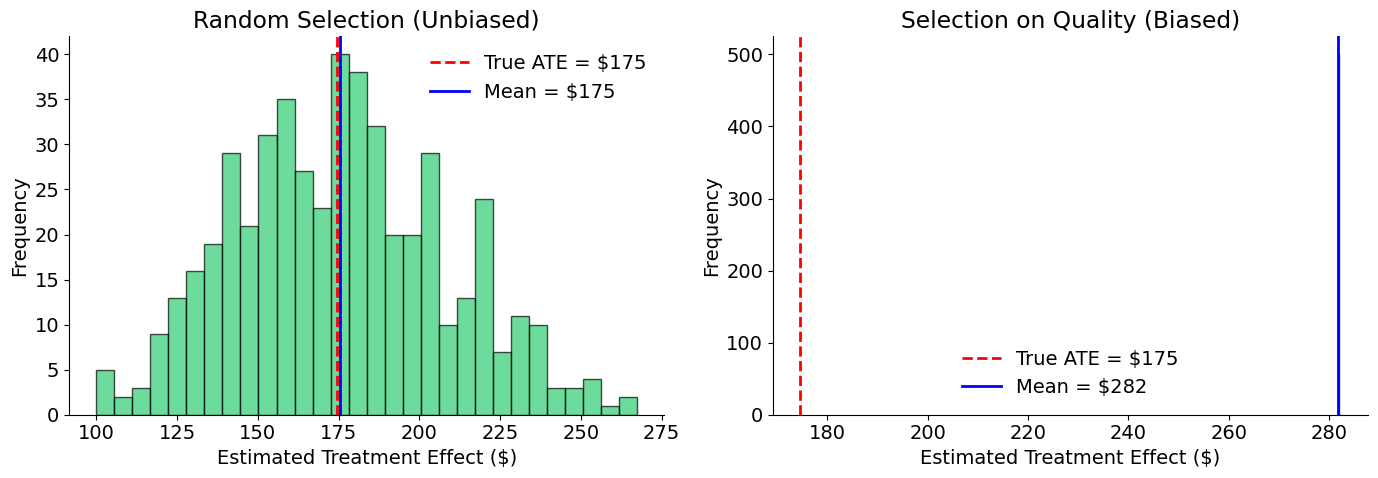

In [21]:
plot_randomization_comparison(random_estimates, biased_estimates, ATE_true)

## SUTVA Considerations for E-commerce

Our simulation assumes SUTVA holds. In real e-commerce settings, we should consider:

| Violation | Example | Implication |
|-----------|---------|-------------|
| **Cannibalization** | Better content on Product A steals sales from Product B | Interference between products |
| **Market saturation** | If ALL products are optimized, relative advantage disappears | Effect depends on treatment prevalence |
| **Budget constraints** | Customers have fixed budgets; more on A means less on B | Zero-sum dynamics |
| **Search ranking effects** | Optimized products rank higher, displacing others | Competitive interference |

---

# Conclusion

## Key Takeaways

1. **The fundamental problem of causal inference**: We can never observe both potential outcomes for the same unit. This is a logical impossibility, not a data limitation.

2. **Individual effects are unidentifiable**: We focus on population averages (ATE, ATT, ATC) because individual treatment effects require observing the unobservable.

3. **The naive estimator is biased under non-random selection**: When treatment assignment correlates with potential outcomes, comparing treated vs. control groups conflates the treatment effect with selection bias.

4. **Randomization solves selection bias**: By ensuring $(Y^0, Y^1) \perp\!\!\!\perp D$, randomized experiments make the naive estimator unbiased.

5. **Covariate balance is a diagnostic**: Imbalance in pre-treatment characteristics signals potential selection bias.

6. **SUTVA is often violated in practice**: Interference between units and variation in treatment implementation are common in business settings.

## When Randomization Isn't Feasible

Randomized experiments are the gold standard, but they're not always possible:
- **Ethical concerns**: Can't randomly deny beneficial treatments
- **Business constraints**: Stakeholders resist random allocation
- **Historical questions**: Past decisions weren't randomized
- **Cost**: Experiments are expensive to run

## What's Next

The remaining lectures in this module cover methods for estimating causal effects from **observational data** where treatment wasn't randomized:

- **Matching & Propensity Scores**: Create comparable groups by conditioning on observables
- **Regression Discontinuity**: Exploit sharp cutoffs in treatment assignment
- **Instrumental Variables**: Use exogenous variation to isolate causal effects
- **Difference-in-Differences**: Leverage parallel trends across time
- **Synthetic Control**: Construct counterfactuals from weighted combinations of controls

Each method relies on different assumptions to identify causal effects when randomization isn't available.